## Optimizing EV Transportation using the Tesla Supercharger Network
 This is the documentation of the network that we have used to optimize using the Tesla Super charger network. We used the dataset of California which had 409 Supercharging stations. Due to our limited computaional resources, we have narrowed down this network to the following.  
 
 1. Our network spans from LA(Downtown) to Santa Maria via Santa Barbara.It  is indicative of sparse and as well as dense network of superchargers.
 
2. The  total number of super chargers in this area is 43.

In [1]:
# Import necessary libraries
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import math
import geopandas as gpd
from shapely.geometry import LineString, Point
import numpy as np
import seaborn as sns

#### Reading Necessary files

1. input.csv - List of node pairs and the distances between them
2. superchargers_nodes.csv - List of supercharger co-ordinates and the nearest node numbers
3. ON_SCS_latlong.csv - Supercharger data for 43 locations which includes Zip and co-ordinates
4. reduced_node_network.csv - List of nodes and their co-ordinates
5. reduced_edge_network.csv - List of nodes and distances

In [2]:
file_path = r"C:\Users\nikhi\OneDrive\Desktop\School\Fall 2023\IE 532\input.csv"
file_path1 = r"C:\Users\nikhi\OneDrive\Desktop\School\Fall 2023\IE 532\supercharger_nodes.csv"
df = pd.read_csv(file_path)
df1 = pd.read_csv(file_path1)
supercharger_data = pd.read_csv(r"C:\Users\nikhi\OneDrive\Desktop\School\Fall 2023\IE 532\Project\Project Data\ON_SCS_latlong.csv")
road_node_data = pd.read_csv(r"C:\Users\nikhi\OneDrive\Desktop\School\Fall 2023\IE 532\Project\Project Data\reduced_node_netowrk.csv")
road_edge_data = pd.read_csv(r"C:\Users\nikhi\OneDrive\Desktop\School\Fall 2023\IE 532\Project\Project Data\reduced_edge_network.csv")

In [3]:
# Sampling 5 nodes to show the working of the model
sample_nodes=df['Node1'].sample(n=5).reset_index(drop=True)

In [4]:
sample_nodes

0    16700
1    17207
2    15788
3    16665
4    16392
Name: Node1, dtype: int64

In [5]:
charger_nodes = df1['Nearest_Node'].tolist()
OD_nodes = [sample_nodes[0],sample_nodes[1]]
concerned_nodes = sorted(OD_nodes + charger_nodes)
node_combinations = list(itertools.combinations(concerned_nodes, 2))
node_pairs = list(itertools.combinations(sample_nodes, 2))
distance_range=1.5
waiting_penalty = 5

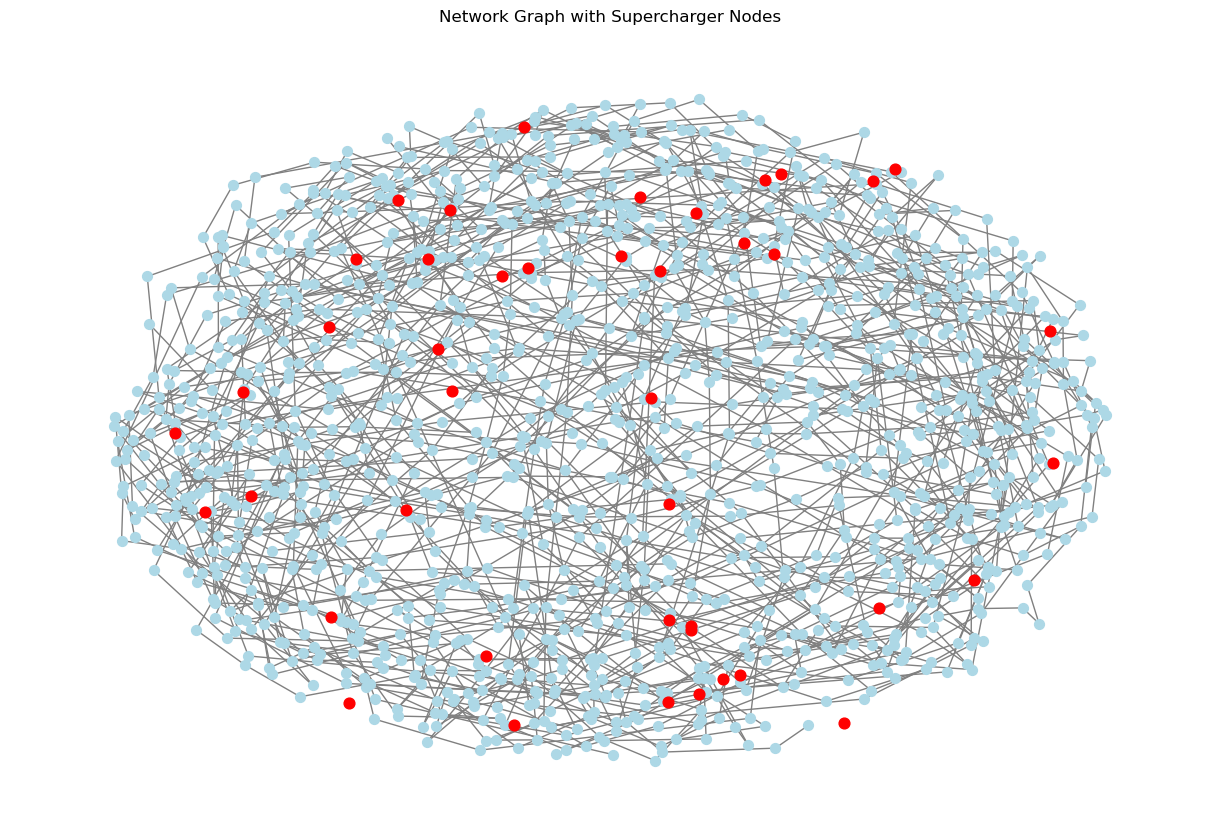

In [6]:
# Create a Graph
G = nx.Graph()

# Adding edges from the DataFrame
# Assuming your CSV has columns 'Node1', 'Node2', and 'Distance' for edges
for _, row in road_edge_data.iterrows():
    G.add_edge(row['Node1'], row['Node2'], weight=row['Distance'])

# Now plot the graph
plt.figure(figsize=(12, 8))

# Draw all the nodes and edges
nx.draw(G, with_labels=False, node_color='lightblue', edge_color='gray', node_size=50)

# Highlight the charger nodes
nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), nodelist=charger_nodes, node_color='red', node_size=60)

plt.title("Network Graph with Supercharger Nodes")
plt.show()

In [7]:
def is_subpath(subpath, path):
    n = len(subpath)
    m = len(path)
    for i in range(m - n + 1):
        if path[i:i + n] == subpath:
            return True
    return False

In [8]:
def remove_subpaths(paths, distances):
    new_paths = []
    new_distances = []

    for i in range(len(paths)):
        add_path = True
        for j in range(len(paths)):
            if i != j and is_subpath(paths[i], paths[j]):
                add_path = False
                break
        if add_path:
            new_paths.append(paths[i])
            new_distances.append(distances[i])
    return new_paths, new_distances

In [9]:
sh_path_ranged = []
sh_path_dist_ranged = []

In [10]:
for s, t in node_combinations:
    shortest_distance = nx.shortest_path_length(G, source=s, target=t, weight='weight')

    if shortest_distance <= distance_range:
        shortest_path = nx.shortest_path(G, source=s, target=t, weight='weight')
        if OD_nodes[1] in shortest_path and shortest_path.index(OD_nodes[1]) == len(shortest_path) - 1:
            sh_path_ranged.append(shortest_path)
            sh_path_dist_ranged.append(shortest_distance)
        elif OD_nodes[1] not in shortest_path:
            sh_path_ranged.append(shortest_path)
            sh_path_dist_ranged.append(shortest_distance)

sh_path_ranged, sh_path_dist_ranged = remove_subpaths(sh_path_ranged, sh_path_dist_ranged)

In [11]:
merged_array_repo = []
distance_repo = []

In [12]:
def merge_arrays(arr1, arr2, dist1, dist2):
    if not arr1 or not arr2:
        return [], 0.0

    merged_array = arr1 + arr2[1:]
    merged_distance = dist1 + dist2

    return merged_array, merged_distance

In [13]:
def recursive_merging(input_array, input_distances):
    global merged_array_repo
    merged_array = []
    combined_listing = list(itertools.combinations(input_array, 2))
    combined_array = [list(combination) for combination in combined_listing]

    to_remove = []

    counter = 0
    for comb in combined_array:
        if comb[0][-1] == comb[1][0]:
            counter += 1

    if counter == 0:
        return merged_array_repo, distance_repo

    for comb in combined_array:
        if comb[0][-1] == comb[1][0]:
            merged_array, merged_distance = merge_arrays(
                comb[0], comb[1:][0], input_distances[input_array.index(comb[0])], input_distances[input_array.index(comb[1:][0])]
            )
            merged_array_repo.append(merged_array)
            distance_repo.append(merged_distance)
            to_remove.extend([comb[0], comb[1:][0]])

    merged_array_repo = [sublist for sublist in merged_array_repo if sublist not in to_remove]

    return recursive_merging(merged_array_repo, distance_repo)

In [14]:
list_of_paths, list_of_distances = recursive_merging(sh_path_ranged, sh_path_dist_ranged)

In [15]:
list_of_paths

[[15237,
  15238.0,
  15239.0,
  15269.0,
  15268.0,
  15310.0,
  15328.0,
  15591.0,
  15592.0,
  15593.0,
  15594.0,
  15595.0,
  15596.0,
  15597.0,
  15598.0,
  15599.0,
  15758.0,
  15759.0,
  15760.0,
  15728.0,
  15784.0,
  15785.0,
  15838.0,
  15837.0,
  15836.0,
  15835.0,
  15834.0,
  15833.0,
  15832.0,
  15831.0,
  15830.0,
  16145.0,
  16144.0,
  16143.0,
  16142.0,
  16141.0,
  16140.0,
  16139.0,
  16138.0,
  16137.0,
  16197.0,
  16198.0,
  16199.0,
  16200.0,
  16201.0,
  16202.0,
  16203.0,
  16204.0,
  16205.0,
  16206.0,
  16207.0,
  16208.0,
  16209.0,
  16210.0,
  16367.0,
  16368.0,
  16369.0,
  16370.0,
  16371.0,
  16372.0,
  16373,
  16374.0,
  16261.0,
  16262.0,
  16265.0,
  16266.0,
  16267.0,
  16269.0,
  16481.0,
  16479.0,
  16528.0,
  16527.0,
  16526.0,
  16525.0,
  16529.0,
  16836.0,
  16835.0,
  16834.0,
  16833.0,
  16832.0,
  16831.0,
  16830.0,
  16829.0,
  16828.0,
  16827.0,
  16826.0,
  16825.0,
  16824.0,
  16823.0,
  16822.0,
  16821.0,
  1

In [16]:
list_of_distances

[1.6848959999999997,
 2.414186999999999,
 2.465884999999999,
 2.448072,
 2.17061,
 1.8409309999999997,
 2.312283999999999,
 2.0232539999999997,
 2.2802999999999995,
 2.40747,
 2.027316,
 2.4290279999999997,
 2.151566,
 1.8908740000000002,
 2.6754729999999998,
 2.8874039999999996,
 2.8582609999999997,
 2.7529829999999995,
 2.882383,
 2.7685189999999995,
 2.6942759999999994,
 2.847753,
 2.693477,
 2.664334,
 2.660799,
 2.626169,
 1.6381610000000002,
 1.895207,
 2.022377,
 1.6422230000000004,
 2.0439350000000003,
 1.7664730000000002,
 1.5057810000000003,
 2.29038,
 2.5023109999999997,
 2.4731680000000003,
 2.36789,
 2.4972900000000005,
 2.383426,
 2.309183,
 2.46266,
 2.1367640000000003,
 2.1287170000000004,
 2.0525370000000005,
 2.0358640000000006,
 2.1252760000000004,
 2.62792,
 2.0040559999999994,
 1.3046169999999997,
 1.4317869999999997,
 1.6098389999999996,
 1.8286769999999994,
 2.0385099999999996,
 2.1104199999999995,
 1.8847549999999997,
 1.6997899999999997,
 1.7810659999999996,
 1

In [17]:
valid_paths = []
valid_distances = []
for each_path, each_distance in zip(list_of_paths, list_of_distances):
    if each_path[0] == OD_nodes[0] and each_path[-1] == OD_nodes[1]:
        valid_paths.append(each_path)
        valid_distances.append(each_distance)

In [18]:
# This finds the shortest path of all the shortest path for the 5C2 combinations
if distance_repo:
    min_distance_index = distance_repo.index(min(distance_repo))

    # Retrieve the corresponding path from list_of_paths
    shortest_path = list_of_paths[min_distance_index]
    shortest_distance = list_of_distances[min_distance_index]

    print(f"\nShortest Path: {shortest_path}, \n\nShortest Distance: {shortest_distance}")
else:
    print("\nNo valid paths found.")


Shortest Path: [15237, 15238.0, 15239.0, 15269.0, 15268.0, 15310.0, 15328.0, 15591.0, 15592.0, 15593.0, 15594.0, 15595.0, 15596.0, 15597.0, 15598.0, 15599.0, 15758.0, 15759.0, 15760.0, 15728.0, 15784.0, 15785.0, 15838.0, 15837.0, 15836.0, 15835.0, 15834.0, 15833.0, 15832.0, 15831.0, 15830.0, 16145.0, 16144.0, 16143.0, 16142.0, 16141.0, 16140.0, 16139.0, 16138.0, 16137.0, 16197.0, 16198.0, 16199.0, 16200.0, 16201.0, 16202.0, 16203.0, 16204.0, 16205.0, 16206.0, 16207.0, 16208.0, 16209.0, 16210.0, 16367.0, 16368.0, 16369.0, 16370.0, 16371.0, 16372.0, 16373, 16374.0, 16261.0, 16262.0, 16265.0, 16266.0, 16267.0, 16269.0, 16481.0, 16479.0, 16480.0, 16366.0, 16365.0, 16662.0, 16661.0, 16660.0, 16659.0, 16658.0, 16657.0, 16656.0, 16655.0, 16654.0, 16653.0, 16652.0, 16651.0, 16650.0, 16649.0, 16648.0, 16647.0, 16646.0, 16645.0, 16644.0, 16643.0, 16642.0, 16641.0, 16640.0, 16639.0, 16638.0, 16637.0, 16636.0, 16635.0, 16634.0, 16633.0, 16632.0, 16631.0, 16630.0, 16629.0, 16628.0, 16627.0, 16626.

In [19]:
def evchargepath(OD_nodes, distance_range, charger_nodes, G):
    try:
        naive_shortest_distance = nx.shortest_path_length(G, source=OD_nodes[0], target=OD_nodes[1], weight='weight')
        if naive_shortest_distance <= distance_range:
            naive_shortest_path = nx.shortest_path(G, source=OD_nodes[0], target=OD_nodes[1], weight='weight')
            return naive_shortest_path, naive_shortest_distance
        else:
            sh_path_ranged = []
            sh_path_dist_ranged = []
            for s, t in node_combinations:
                shortest_distance = nx.shortest_path_length(G, source=s, target=t, weight='weight')
                if shortest_distance <= distance_range:
                    shortest_path = nx.shortest_path(G, source=s, target=t, weight='weight')
                    if OD_nodes[1] in shortest_path and shortest_path.index(OD_nodes[1]) == len(shortest_path) - 1:
                        sh_path_ranged.append(shortest_path)
                        sh_path_dist_ranged.append(shortest_distance)
                    elif OD_nodes[1] not in shortest_path:
                        sh_path_ranged.append(shortest_path)
                        sh_path_dist_ranged.append(shortest_distance)

            sh_path_ranged, sh_path_dist_ranged = remove_subpaths(sh_path_ranged, sh_path_dist_ranged)
            global merged_array_repo
            global distance_repo
            merged_array_repo = []
            distance_repo = []

            list_of_paths, list_of_distances = recursive_merging(sh_path_ranged, sh_path_dist_ranged)
            valid_paths = []
            valid_distances = []
            for each_path, each_distance in zip(list_of_paths, list_of_distances):
                if each_path[0] == OD_nodes[0] and each_path[-1] == OD_nodes[1]:
                    valid_paths.append(each_path)
                    valid_distances.append(each_distance)
            if valid_distances:
                min_distance_index = valid_distances.index(min(valid_distances))
                return valid_paths[min_distance_index], valid_distances[min_distance_index]
            else:
                return [], -1
    except nx.NetworkXNoPath:
        return [], -1

In [20]:
# Create a GeoDataFrame for the nodes
gdf_nodes = gpd.GeoDataFrame(
    road_node_data, 
    geometry=gpd.points_from_xy(road_node_data['Longitude'], road_node_data['Latitude'])
)

# Assuming 'df' contains edge information with 'Node1' and 'Node2'
edge_list = []
for _, edge in road_edge_data.iterrows():
    node1_coords = gdf_nodes.loc[gdf_nodes['Node'] == edge['Node1']].geometry.values[0]
    node2_coords = gdf_nodes.loc[gdf_nodes['Node'] == edge['Node2']].geometry.values[0]
    edge_list.append(LineString([node1_coords, node2_coords]))

gdf_edges = gpd.GeoDataFrame(geometry=edge_list)

In [21]:
# Create GeoDataFrame for superchargers
supercharger_points = gpd.GeoDataFrame(
    supercharger_data, 
    geometry=gpd.points_from_xy(supercharger_data['Longitude'], supercharger_data['Latitude'])
)

In [22]:
'''
# Calculate shortest path
shortest_path, shortest_distance = evchargepath(OD_nodes, distance_range, charger_nodes, G)

# Extract the coordinates for the shortest path
shortest_path_coords = [gdf_nodes.loc[gdf_nodes['Node'] == node].geometry.values[0] for node in shortest_path]
gdf_shortest_path = gpd.GeoDataFrame(geometry=[LineString(shortest_path_coords)])

# Plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plotting the edges
gdf_edges.plot(ax=ax, linewidth=1, color='gray')

# Plotting the nodes
gdf_nodes.plot(ax=ax, color='blue', marker='o', label='Nodes', markersize=5)

# Plotting the shortest path
gdf_shortest_path.plot(ax=ax, linewidth=5, color='red', label='Shortest Path')

# Add grid, legend, and title
ax.grid(True)
ax.legend()
ax.set_title("Nodes, Superchargers, and Shortest Path Network")

plt.show()
'''

'\n# Calculate shortest path\nshortest_path, shortest_distance = evchargepath(OD_nodes, distance_range, charger_nodes, G)\n\n# Extract the coordinates for the shortest path\nshortest_path_coords = [gdf_nodes.loc[gdf_nodes[\'Node\'] == node].geometry.values[0] for node in shortest_path]\ngdf_shortest_path = gpd.GeoDataFrame(geometry=[LineString(shortest_path_coords)])\n\n# Plot\nfig, ax = plt.subplots(figsize=(20, 20))\n\n# Plotting the edges\ngdf_edges.plot(ax=ax, linewidth=1, color=\'gray\')\n\n# Plotting the nodes\ngdf_nodes.plot(ax=ax, color=\'blue\', marker=\'o\', label=\'Nodes\', markersize=5)\n\n# Plotting the shortest path\ngdf_shortest_path.plot(ax=ax, linewidth=5, color=\'red\', label=\'Shortest Path\')\n\n# Add grid, legend, and title\nax.grid(True)\nax.legend()\nax.set_title("Nodes, Superchargers, and Shortest Path Network")\n\nplt.show()\n'

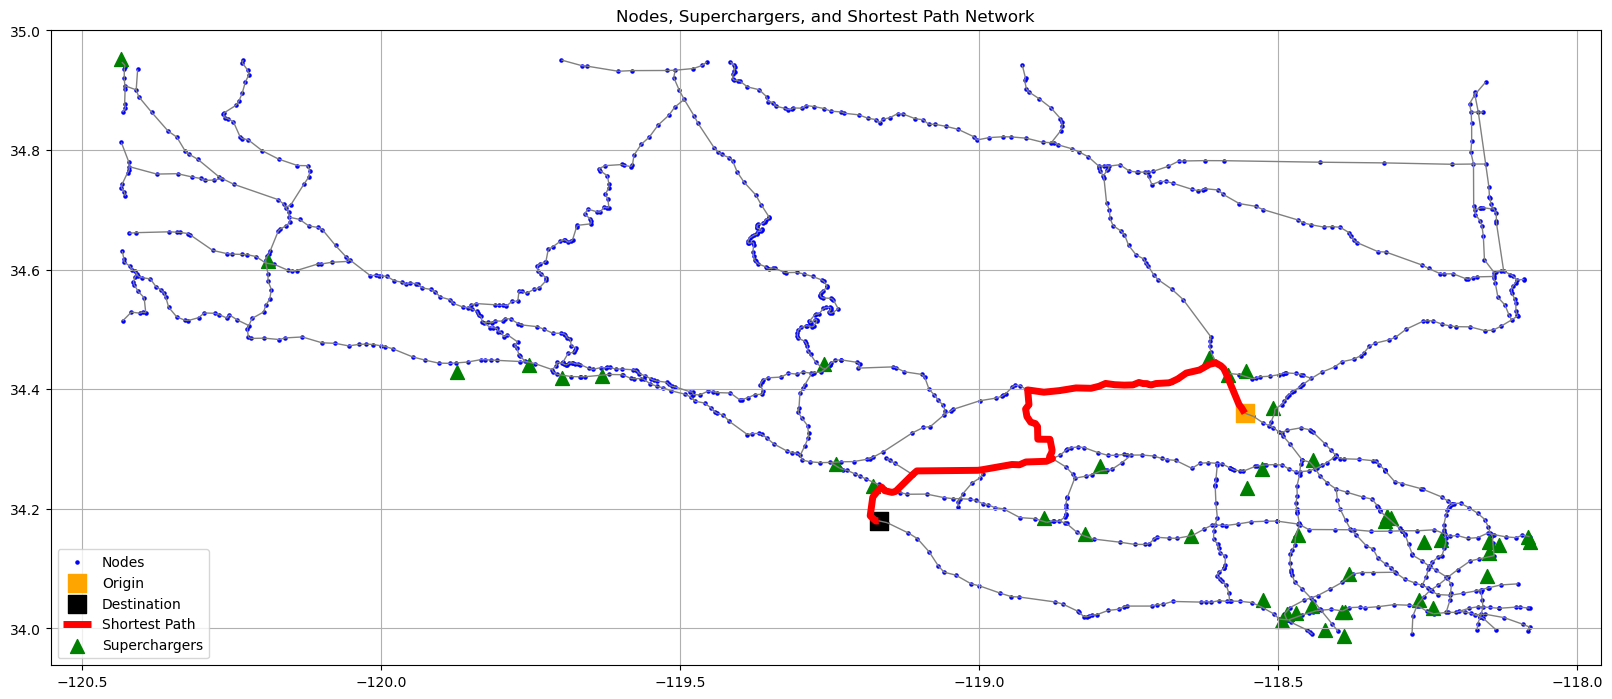

In [23]:
# Calculate shortest path
shortest_path, shortest_distance = evchargepath(OD_nodes, distance_range, charger_nodes, G)
origin_node = OD_nodes[0]  # First node is the origin
destination_node = OD_nodes[1]  # Second node is the destination

# Extract coordinates for the shortest path
shortest_path_coords = [gdf_nodes.loc[gdf_nodes['Node'] == node].geometry.values[0] for node in shortest_path]
gdf_shortest_path = gpd.GeoDataFrame(geometry=[LineString(shortest_path_coords)])

# Plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plotting edges
gdf_edges.plot(ax=ax, linewidth=1, color='gray')

# Plotting nodes and highlighting origin and destination nodes
gdf_nodes.plot(ax=ax, color='blue', marker='o', label='Nodes', markersize=5)

# Extracting coordinates for origin and destination nodes
origin_coords = gdf_nodes.loc[gdf_nodes['Node'] == origin_node].geometry.values[0]
destination_coords = gdf_nodes.loc[gdf_nodes['Node'] == destination_node].geometry.values[0]

# Plotting origin node and destination node
gdf_nodes[gdf_nodes['Node'] == origin_node].plot(ax=ax, color='orange', marker='s', label='Origin', markersize=150)
gdf_nodes[gdf_nodes['Node'] == destination_node].plot(ax=ax, color='black', marker='s', label='Destination', markersize=150)

# Plotting shortest path
gdf_shortest_path.plot(ax=ax, linewidth=5, color='red', label='Shortest Path')

# Plotting superchargers
supercharger_points.plot(ax=ax, color='green', marker='^', label='Superchargers', markersize=100)

# Add grid, legend, and title
ax.grid(True)
ax.legend()
ax.set_title("Nodes, Superchargers, and Shortest Path Network")

plt.show()


Origin :  16700
Destination :  17207
Shortest Path :  [16700, 16701.0, 16702.0, 16494.0, 16495.0, 16496.0, 16319.0, 16561.0, 16562.0, 16563.0, 16564.0, 16565.0, 16566.0, 16567.0, 16568.0, 16569.0, 16570.0, 16571.0, 16572.0, 16573.0, 16574.0, 16575.0, 16576.0, 16577.0, 16578.0, 16579.0, 16580.0, 16581.0, 16582.0, 16860.0, 16861.0, 16862.0, 16863.0, 16864.0, 16865.0, 16866.0, 16867.0, 16868.0, 16869.0, 16870.0, 16859.0, 16888.0, 16944.0, 16943.0, 16942.0, 16941.0, 16976.0, 16977.0, 16978.0, 17068.0, 17069.0, 17070.0, 17067.0, 17064.0, 17042.0, 17211.0, 17210.0, 17209.0, 17208.0, 17207]
Shortest Distance :  0.952861  including the distance of  0  that could have been travelled instead of charging


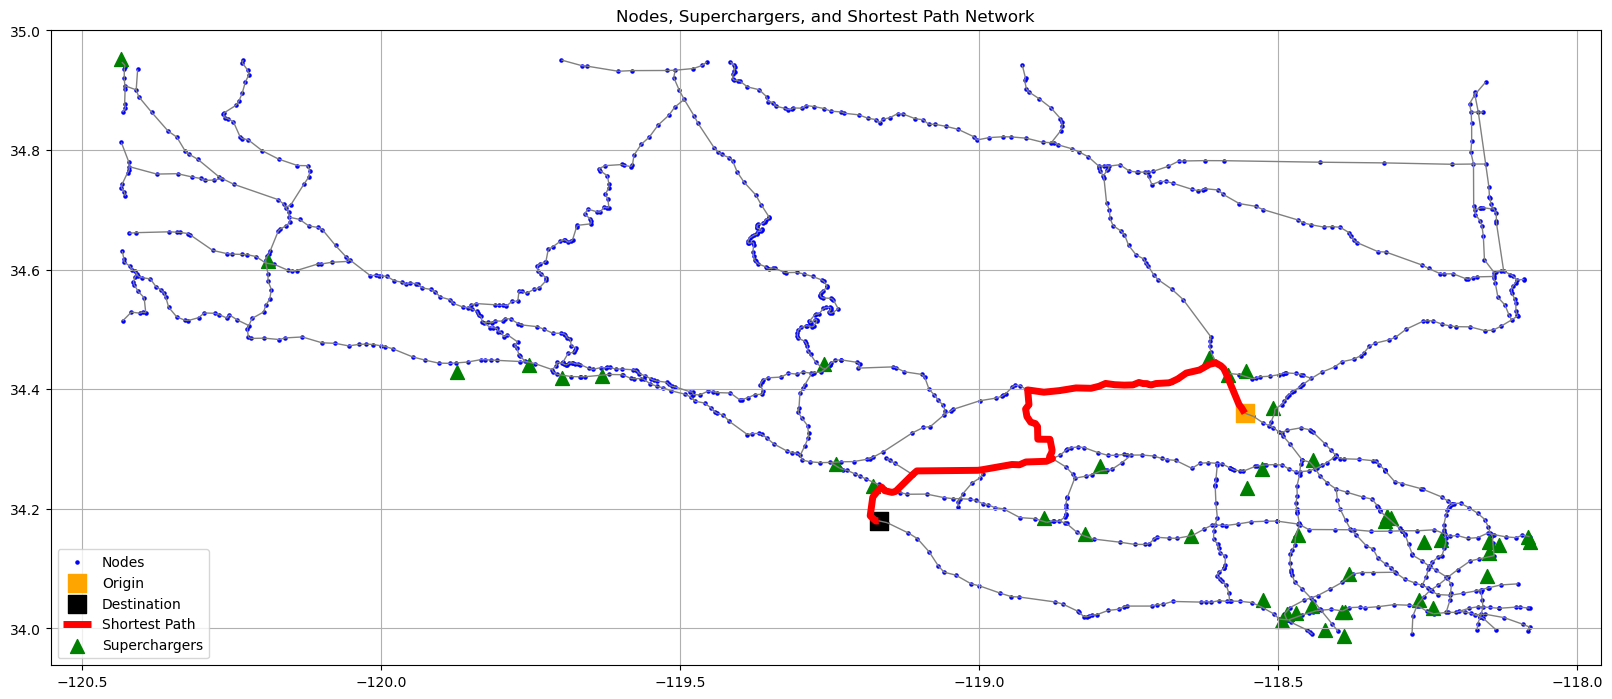

Origin :  15788
Destination :  16700
Shortest Path :  [15788, 15848.0, 15857.0, 15858.0, 15859.0, 15877.0, 16109.0, 16110.0, 16111.0, 16112.0, 16113.0, 16108.0, 16530.0, 16531.0, 16532.0, 16533.0, 16534.0, 16535.0, 16536.0, 16537.0, 16538.0, 16539.0, 16540.0, 16541.0, 16542.0, 16543.0, 16544.0, 16545.0, 16546.0, 16547.0, 16548.0, 16549.0, 16550.0, 16551.0, 16557.0, 16558.0, 16559.0, 16560.0, 16689.0, 16690.0, 16691.0, 16692.0, 16693.0, 16694.0, 16695.0, 16696.0, 16697.0, 16698.0, 16699.0, 16700]
Shortest Distance :  0.709012  including the distance of  0  that could have been travelled instead of charging


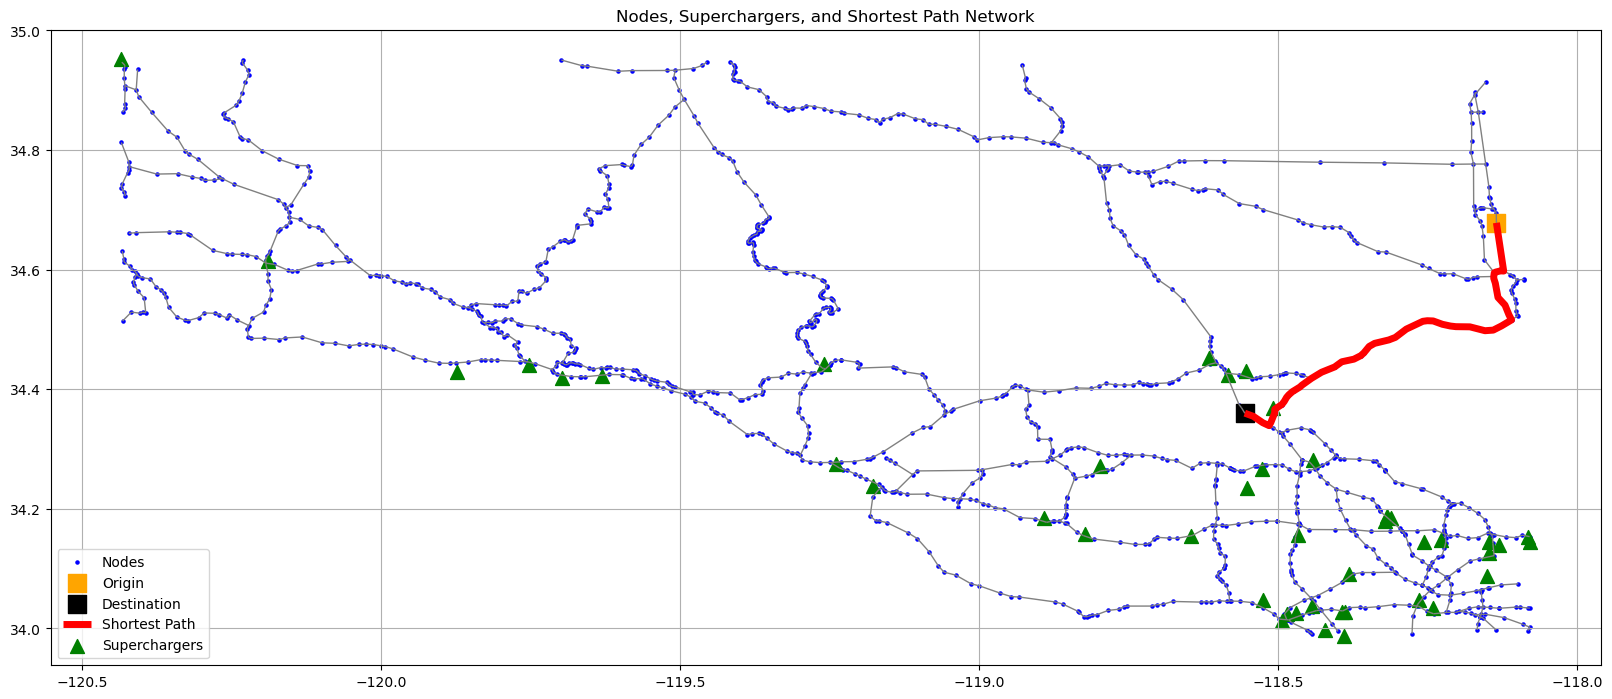

Origin :  15788
Destination :  17207
Shortest Path :  []
Shortest Distance :  -6  including the distance of  -5  that could have been travelled instead of charging


C:\Users\nikhi\anaconda3\Lib\site-packages\geopandas\plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)


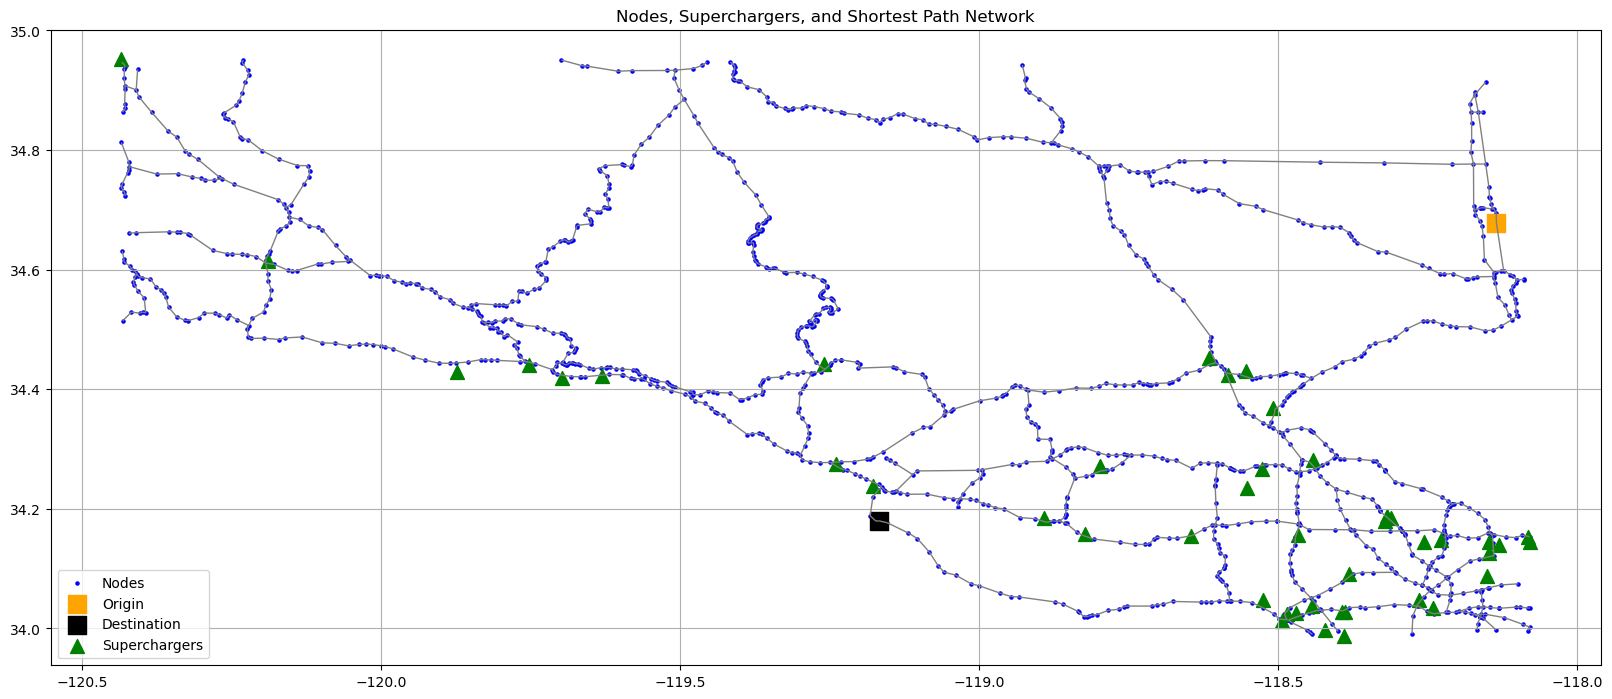

Origin :  15788
Destination :  16665
Shortest Path :  [15788, 15848.0, 15857.0, 15858.0, 15859.0, 15877.0, 16109.0, 16110.0, 16111.0, 16112.0, 16113.0, 16108.0, 16530.0, 16531.0, 16532.0, 16533.0, 16534.0, 16535.0, 16536.0, 16537.0, 16538.0, 16539.0, 16540.0, 16541.0, 16542.0, 16543.0, 16544.0, 16545.0, 16546.0, 16547.0, 16548.0, 16549.0, 16550.0, 16551.0, 16521.0, 16522.0, 16523.0, 16524.0, 16500.0, 16501.0, 16502.0, 16555.0, 16554.0, 16553.0, 16552.0, 16556.0, 16494.0, 16495.0, 16496.0, 16319.0, 16561.0, 16562.0, 16563.0, 16564.0, 16565.0, 16566.0, 16567.0, 16568.0, 16569.0, 16570.0, 16571.0, 16572.0, 16573.0, 16574.0, 16575.0, 16576.0, 16577.0, 16578.0, 16579.0, 16580.0, 16581.0, 16582.0, 16588.0, 16587.0, 16586.0, 16585.0, 16584.0, 16583.0, 16678.0, 16677.0, 16676.0, 16675.0, 16674.0, 16679.0, 16681.0, 16680.0, 16663.0, 16664.0, 16665]
Shortest Distance :  1.2561349999999996  including the distance of  0  that could have been travelled instead of charging


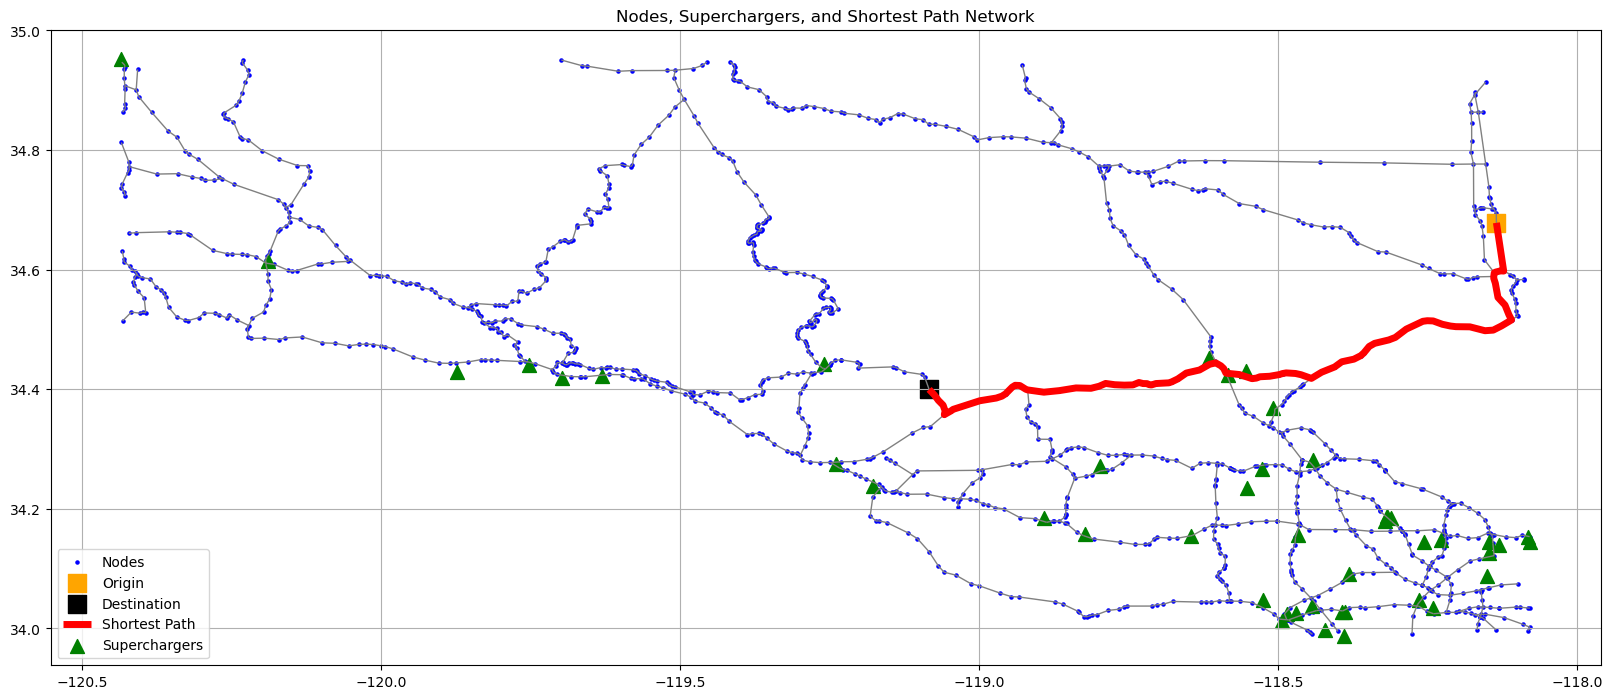

Origin :  15788
Destination :  16392
Shortest Path :  []
Shortest Distance :  -6  including the distance of  -5  that could have been travelled instead of charging


C:\Users\nikhi\anaconda3\Lib\site-packages\geopandas\plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)


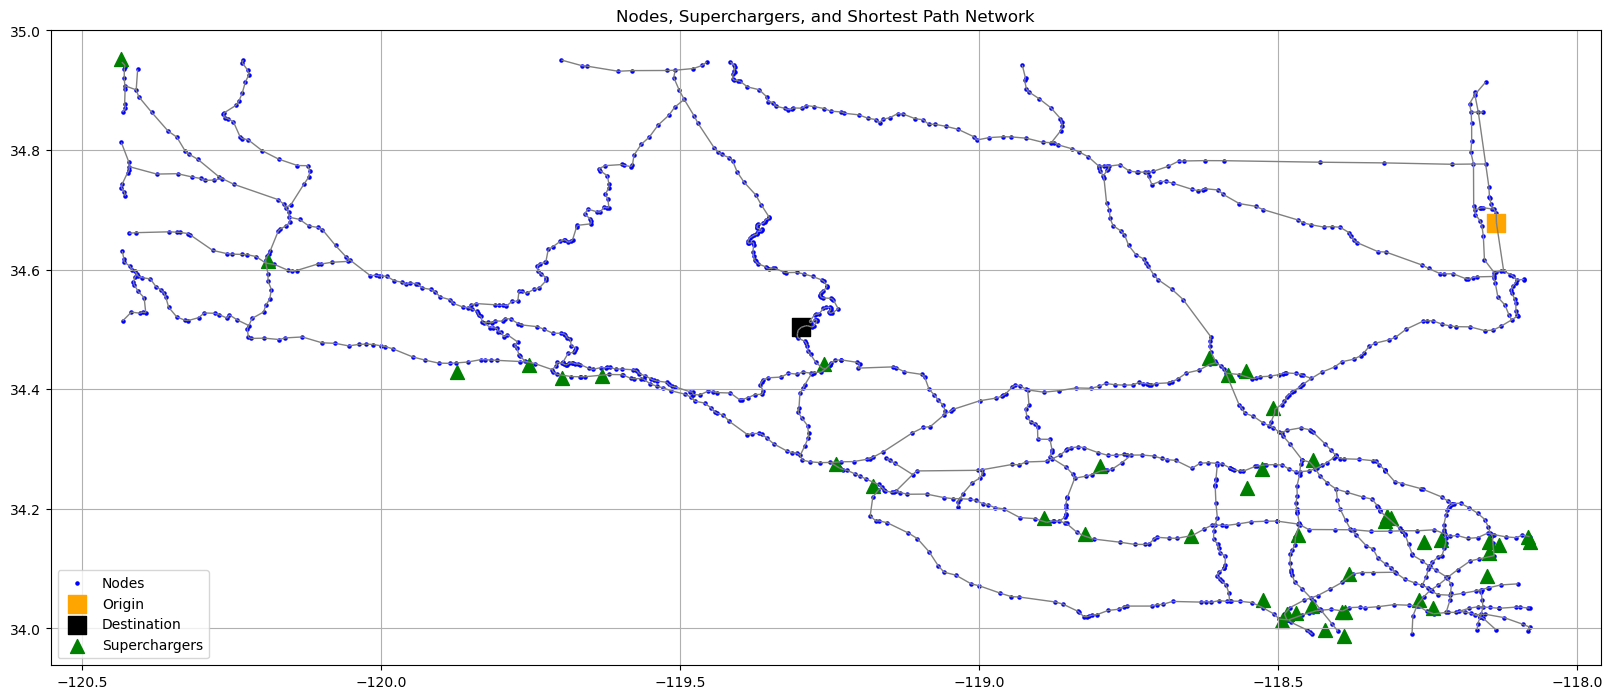

Origin :  16665
Destination :  16700
Shortest Path :  [16665, 16664.0, 16663.0, 16680.0, 16681.0, 16679.0, 16674.0, 16675.0, 16676.0, 16677.0, 16678.0, 16583.0, 16584.0, 16585.0, 16586.0, 16587.0, 16588.0, 16582.0, 16581.0, 16580.0, 16579.0, 16578.0, 16577.0, 16576.0, 16575.0, 16574.0, 16573.0, 16572.0, 16571.0, 16570.0, 16569.0, 16568.0, 16567.0, 16566.0, 16565.0, 16564.0, 16563.0, 16562.0, 16561.0, 16319.0, 16496.0, 16495.0, 16494.0, 16702.0, 16701.0, 16700]
Shortest Distance :  0.6313190000000001  including the distance of  0  that could have been travelled instead of charging


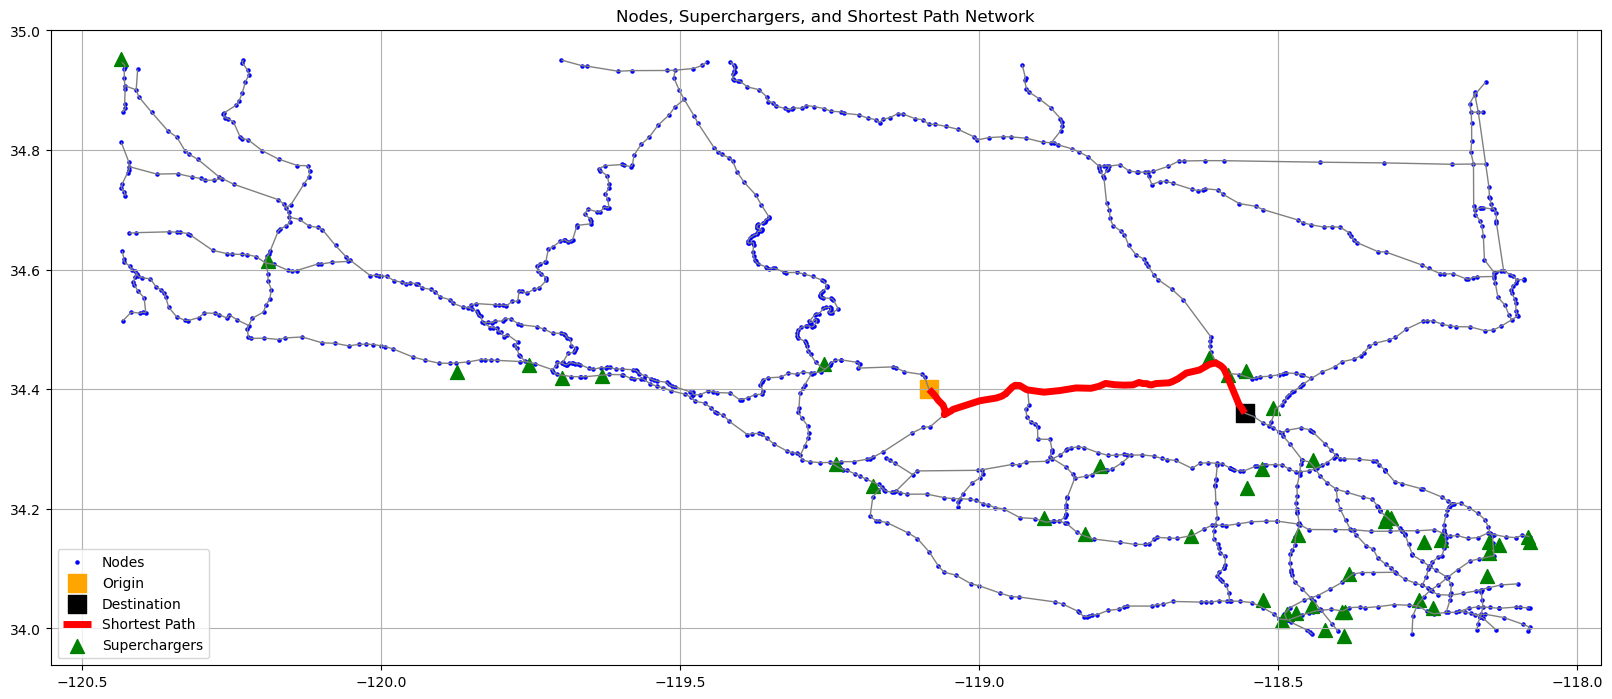

Origin :  16665
Destination :  17207
Shortest Path :  [16665, 16664.0, 16663.0, 16680.0, 16681.0, 16679.0, 16703.0, 16857.0, 16856.0, 16855.0, 16854.0, 16874.0, 16873.0, 16889.0, 16891.0, 16892.0, 16907.0, 16908.0, 16975.0, 16974.0, 16973.0, 16999.0, 17038.0, 17037.0, 17042.0, 17211.0, 17210.0, 17209.0, 17208.0, 17207]
Shortest Distance :  0.431755  including the distance of  0  that could have been travelled instead of charging


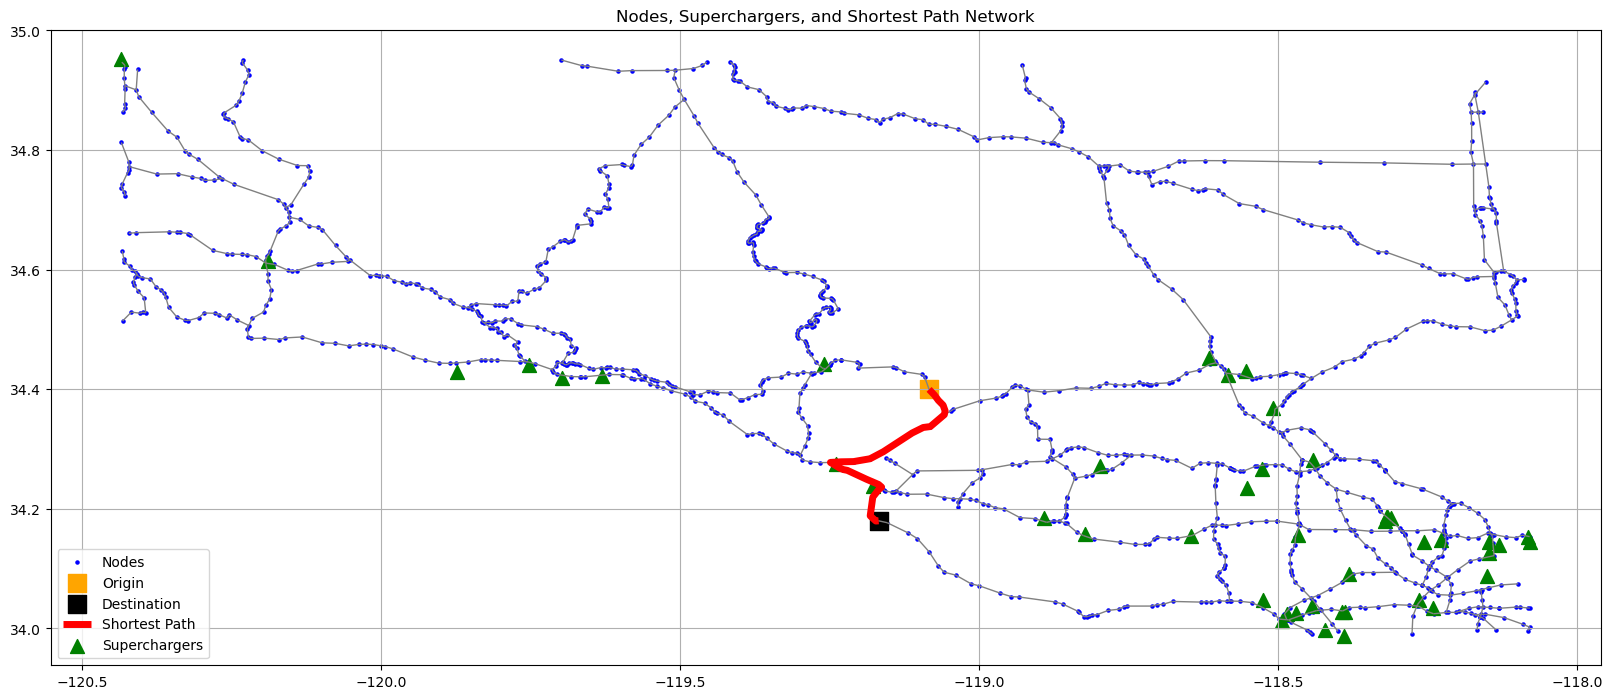

Origin :  16392
Destination :  16700
Shortest Path :  [16392, 16391.0, 16390.0, 16389.0, 16388.0, 16387.0, 16386.0, 16385.0, 16384.0, 16383.0, 16382.0, 16381.0, 16380.0, 16379.0, 16378.0, 16375.0, 16376.0, 16377.0, 16264.0, 16263.0, 16673.0, 16672.0, 16671.0, 16670.0, 16669.0, 16668.0, 16667.0, 16666.0, 16665.0, 16664.0, 16663.0, 16680.0, 16681.0, 16679.0, 16674.0, 16675.0, 16676.0, 16677.0, 16678.0, 16583.0, 16584.0, 16585.0, 16586.0, 16587.0, 16588.0, 16582.0, 16581.0, 16580.0, 16579.0, 16578.0, 16577.0, 16576.0, 16575.0, 16574.0, 16573.0, 16572.0, 16571.0, 16570.0, 16569.0, 16568.0, 16567.0, 16566.0, 16565.0, 16564.0, 16563.0, 16562.0, 16561.0, 16319.0, 16496.0, 16495.0, 16494.0, 16702.0, 16701.0, 16700]
Shortest Distance :  0.9336389999999997  including the distance of  0  that could have been travelled instead of charging


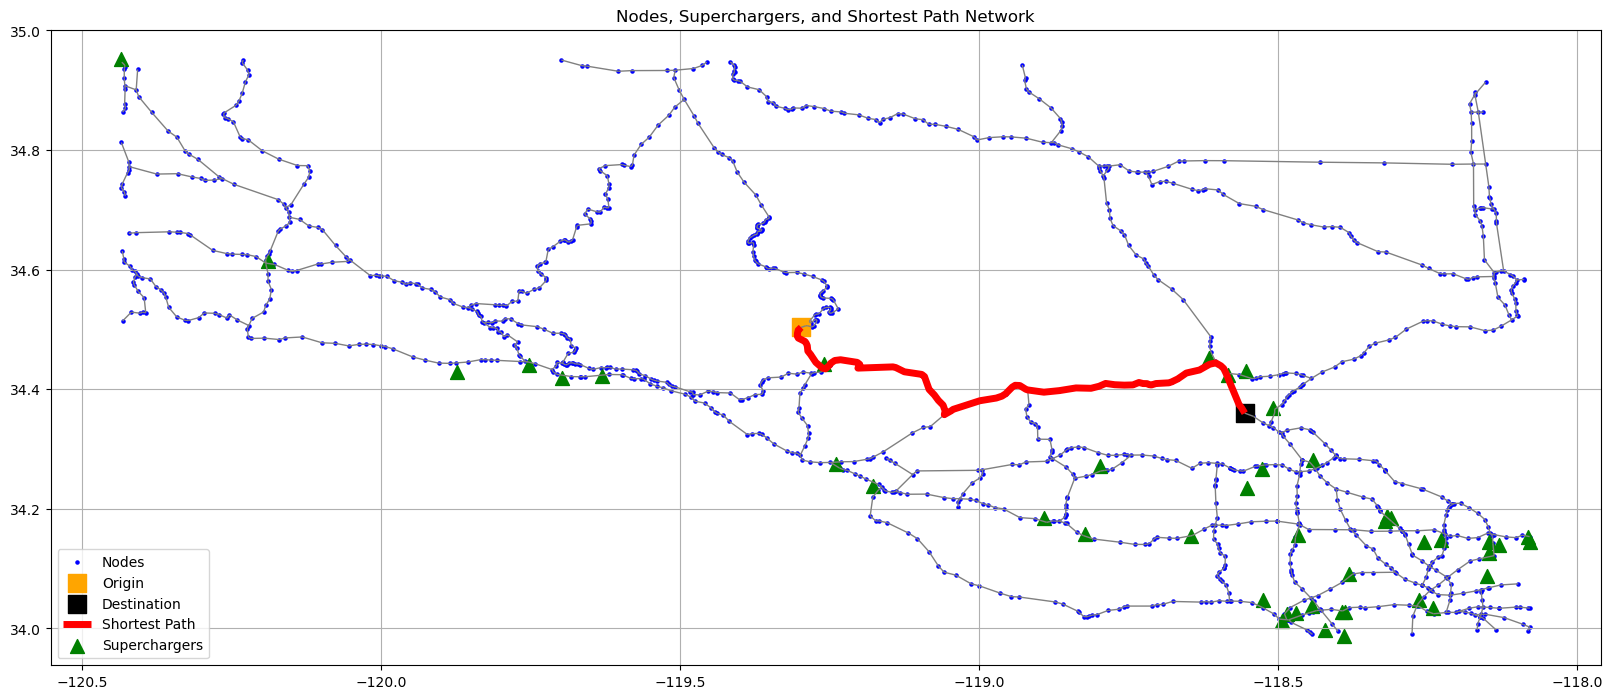

Origin :  16392
Destination :  17207
Shortest Path :  [16392, 16391.0, 16390.0, 16389.0, 16388.0, 16387.0, 16386.0, 16385.0, 16384.0, 16383.0, 16382.0, 16381.0, 16380.0, 16379.0, 16497.0, 16498.0, 16499.0, 16688.0, 16687.0, 16686.0, 16685.0, 16684.0, 16683.0, 16682.0, 16806.0, 16805.0, 16804.0, 16803.0, 16883.0, 16893.0, 16894.0, 16892.0, 16907.0, 16908.0, 16975.0, 16974.0, 16973.0, 16999.0, 17038.0, 17037.0, 17042.0, 17211.0, 17210.0, 17209.0, 17208.0, 17207]
Shortest Distance :  0.4925149999999999  including the distance of  0  that could have been travelled instead of charging


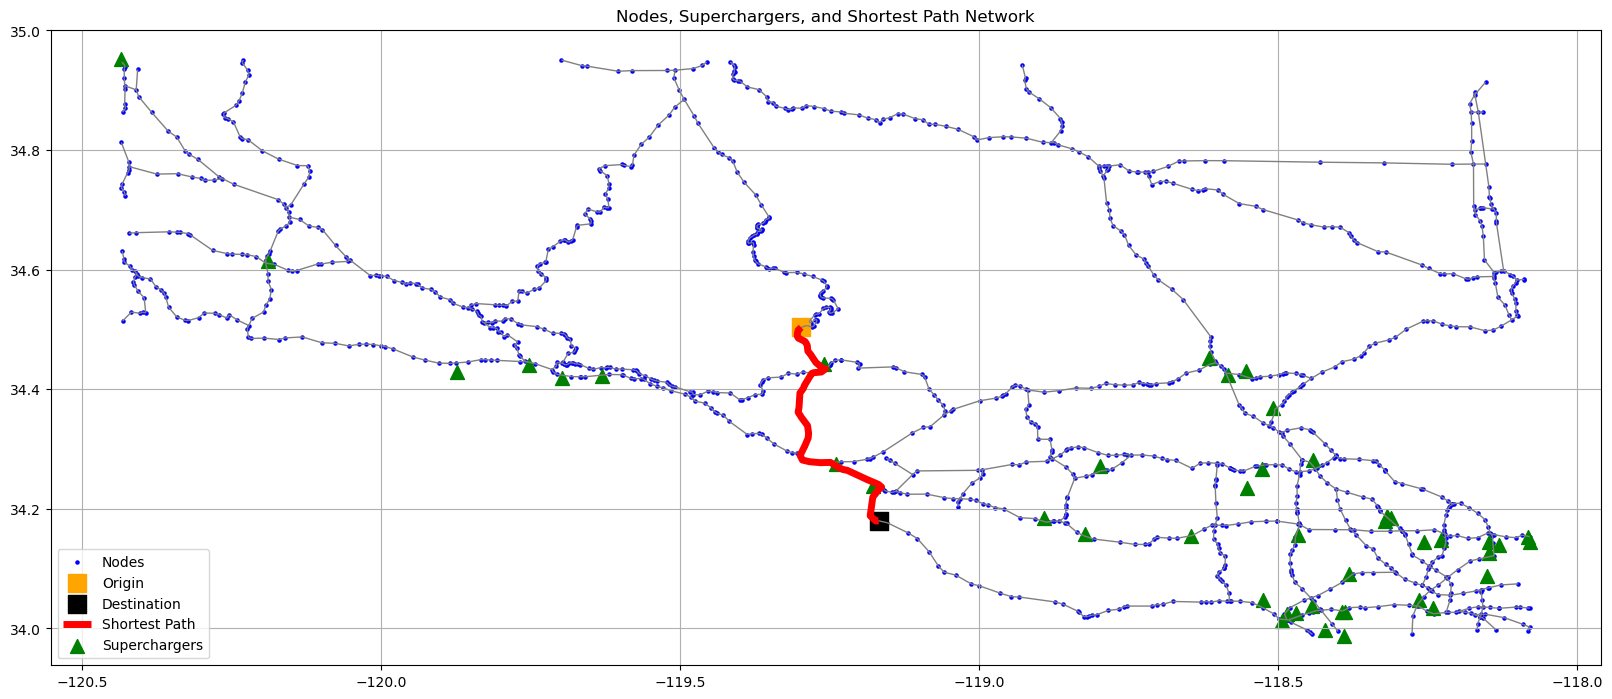

Origin :  16392
Destination :  16665
Shortest Path :  [16392, 16391.0, 16390.0, 16389.0, 16388.0, 16387.0, 16386.0, 16385.0, 16384.0, 16383.0, 16382.0, 16381.0, 16380.0, 16379.0, 16378.0, 16375.0, 16376.0, 16377.0, 16264.0, 16263.0, 16673.0, 16672.0, 16671.0, 16670.0, 16669.0, 16668.0, 16667.0, 16666.0, 16665]
Shortest Distance :  0.30232000000000003  including the distance of  0  that could have been travelled instead of charging


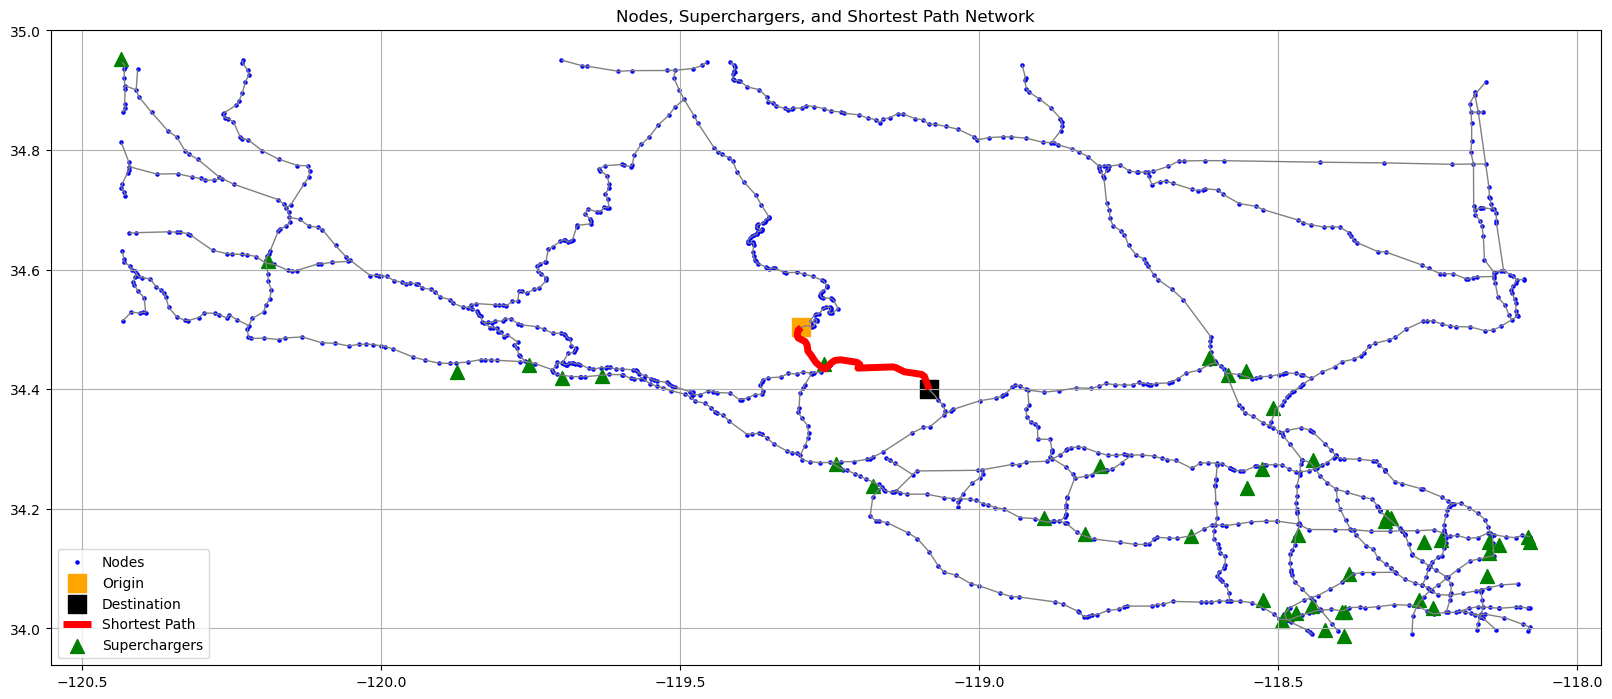

In [24]:
heatmap_data = {}

for origin in sample_nodes:
    for destination in sample_nodes:
        # if i<j and i not in charger_nodes and j not in charger_nodes:
        if origin<destination:
            
            penalty = 0
            OD_nodes[0] = origin
            OD_nodes[1] = destination
            print("Origin : ", OD_nodes[0])
            print("Destination : ",OD_nodes[1])
            
            shortest_path, shortest_distance = evchargepath(OD_nodes, distance_range, charger_nodes, G)
            
            penalty = math.floor(shortest_distance/distance_range)*waiting_penalty
            final_shortest_distance = shortest_distance+penalty

            heatmap_data[(OD_nodes[0], OD_nodes[1])] = final_shortest_distance
            
            print("Shortest Path : ",shortest_path)
            print("Shortest Distance : ", final_shortest_distance , " including the distance of ",penalty, " that could have been travelled instead of charging")

            # Extract coordinates for the shortest path
            shortest_path_coords = [gdf_nodes.loc[gdf_nodes['Node'] == node].geometry.values[0] for node in shortest_path]
            gdf_shortest_path = gpd.GeoDataFrame(geometry=[LineString(shortest_path_coords)])

            # Plot
            fig, ax = plt.subplots(figsize=(20, 20))

            # Plotting edges
            gdf_edges.plot(ax=ax, linewidth=1, color='gray')

            # Plotting nodes
            gdf_nodes.plot(ax=ax, color='blue', marker='o', label='Nodes', markersize=5)
            
            # Extracting coordinates for origin and destination nodes
            origin_coords = gdf_nodes.loc[gdf_nodes['Node'] == origin].geometry.values[0]
            destination_coords = gdf_nodes.loc[gdf_nodes['Node'] == destination].geometry.values[0]

            # Plotting origin node and destination node
            gdf_nodes[gdf_nodes['Node'] == origin].plot(ax=ax, color='orange', marker='s', label='Origin', markersize=150)
            gdf_nodes[gdf_nodes['Node'] == destination].plot(ax=ax, color='black', marker='s', label='Destination', markersize=150)


            # Plotting shortest path
            gdf_shortest_path.plot(ax=ax, linewidth=5, color='red', label='Shortest Path')

            # Plotting superchargers
            supercharger_points.plot(ax=ax, color='green', marker='^', label='Superchargers', markersize=100)

            # Add grid, legend, and title
            ax.grid(True)
            ax.legend()
            ax.set_title("Nodes, Superchargers, and Shortest Path Network")

            plt.show()


			 HEAT MAP


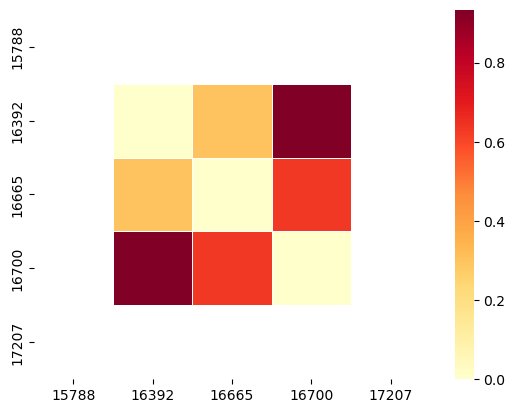

In [25]:
print("="*100)
print("\t"*3,"HEAT MAP")
print("="*100)

# Create a DataFrame for the heatmap
df_heatmap = pd.DataFrame(list(heatmap_data.items()), columns=['OD_nodes', 'final_shortest_distance'])

# Split 'OD_nodes' into two separate columns
df_heatmap[['Origin_node', 'Destination_node']] = pd.DataFrame(df_heatmap['OD_nodes'].tolist(), index=df_heatmap.index)

# Pivot the DataFrame to create a matrix for the heatmap
heatmap_matrix = df_heatmap.pivot(index='Origin_node', columns='Destination_node', values='final_shortest_distance')

heatmap_matrix[np.isnan(heatmap_matrix)]=0
heatmap_matrix = heatmap_matrix + heatmap_matrix.transpose()

mask = (heatmap_matrix == -1)
heatmap_matrix_colored = heatmap_matrix.mask(mask, -1)
# Create the heatmap using seaborn
sns.heatmap(heatmap_matrix, annot=False, cmap="YlOrRd", fmt=".1f", linewidths=.5)
# sns.heatmap(heatmap_matrix, annot=False, cmap="Reds", fmt=".1f", linewidths=.5, vmin=-1, vmax=heatmap_matrix.values.max(), cbar_kws={'label': 'Final Shortest Distance'})

# # Add red color for cells with value -1
# sns.heatmap(heatmap_matrix, mask=(heatmap_matrix == -1), cmap='Reds', cbar=False, annot=False)

# Show the plot
plt.show()